### Chapter 8

### Neural style transfer

In addition to DeepDream, another major development in deep-learning-driven
image modification is neural style transfer, introduced by Leon Gatys et al. in the summer of 2015.

The neural style transfer algorithm has undergone many refinements
and spawned many variations since its original introduction, and it has made its way
into many smartphone photo apps. For simplicity, we will focuses on the formulation described in the original paper.
 
Neural style transfer consists of applying the style of a reference image to a target
image while conserving the content of the target image. Figure shows an example.

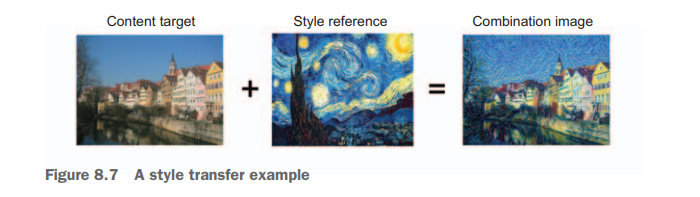

In this context, style essentially means textures, colors, and visual patterns in the image, at
various spatial scales; and the content is the higher-level macrostructure of the image.

For instance, blue-and-yellow circular brushstrokes are considered to be the style in figure above (using Starry Night by Vincent Van Gogh), and the buildings in the Tübingen
photograph are considered to be the content.
 
The idea of style transfer, which is tightly related to that of texture generation, has
had a long history in the image-processing community prior to the development of
neural style transfer in 2015. But as it turns out, the deep-learning-based implementations of style transfer offer results unparalleled by what had been previously achieved
with classical computer-vision techniques, and they triggered an amazing renaissance
in creative applications of computer vision.
 
The key notion behind implementing style transfer is the same idea that’s central
to all deep-learning algorithms: 
* We define a loss function to specify what we want to
achieve, and we minimize this loss. 

We know what we want to achieve: 
* Conserving
the content of the original image while adopting the style of the reference image. If
we were able to mathematically define content and style, then an appropriate loss function to minimize would be the following:

`loss = distance(style(reference_image) - style(generated_image)) + distance(content(original_image) - content(generated_image))`

Here, `distance` is a norm function such as the `L2 norm`, content is a function that
takes an image and computes a representation of its content, and `style` is a function
that takes an image and computes a representation of its style.

Minimizing this
loss causes `style(generated_image)` to be close to `style(reference_image)`, and
`content(generated_image)` is close to `content(generated_image)`, thus achieving
style transfer as we defined it.
 
A fundamental observation made by Gatys et al. was that deep convolutional neural networks offer a way to mathematically define the `style` and `content` functions.

### The content loss

As we already know, activations from earlier layers in a network contain local information about the image, whereas activations from higher layers contain increasingly global,
abstract information. 

Formulated in a different way, the activations of the different layers of a convnet provide a decomposition of the contents of an image over different spatial scales. Therefore, we’d expect the content of an image, which is more global and
abstract, to be captured by the representations of the upper layers in a convnet.

A good candidate for content loss is thus the `L2 norm` between 
* the activations of
an upper layer in a pretrained convnet, computed over the target image, and 
* the activations of the same layer computed over the generated image. 

This guarantees that, as
seen from the upper layer, the generated image will look similar to the original target
image. Assuming that what the upper layers of a convnet see is really the content of
their input images, then this works as a way to preserve image content. 

### The style loss

The `content loss` only uses a single upper layer, but the `style loss` as defined by Gatys
et al. uses multiple layers of a convnet:
* We try to capture the appearance of the style-reference image at all spatial scales extracted by the convnet, not just a single scale. For the style loss, Gatys et al. use the `Gram matrix` of a layer’s activations: the inner
product of the feature maps of a given layer. 

This inner product can be understood as
representing a map of the correlations between the layer’s features. These feature correlations capture the statistics of the patterns of a particular spatial scale, which empirically correspond to the appearance of the textures found at this scale.
 
Hence, the style loss aims to preserve similar internal correlations within the activations of different layers, across the style-reference image and the generated image. In
turn, this guarantees that the textures found at different spatial scales look similar
across the style-reference image and the generated image.
 
In short, we can use a pretrained convnet to define a loss that will do the following:

* Preserve content by maintaining similar high-level layer activations between the
target content image and the generated image. The convnet should **see** both
the target image and the generated image as containing the same things.
* Preserve style by maintaining similar `correlations` within activations for both low-level layers and high-level layers. Feature correlations capture `textures`: the generated image and the style-reference image should share the same textures at
different spatial scales.

Now, let’s look at a Keras implementation of the original 2015 neural style transfer
algorithm. As we’ll see, it shares many similarities with the DeepDream implementation developed in last file

### Neural style transfer in Keras

Neural style transfer can be implemented using any pretrained convnet. Here, we’ll
use the VGG19 network used by Gatys et al. VGG19 is a simple variant of the VGG16 network, with three more convolutional layers.
 
This is the general process:
1. Set up a network that computes VGG19 layer activations for the 
    * style-reference
image, 
    * the target image, and 
    * the generated image at the same time.
2. Use the layer activations computed over these three images to define the loss
function described earlier, which we’ll minimize in order to achieve style
transfer.
3. Set up a gradient-descent process to minimize this loss function.

Let’s start by defining the paths to the style-reference image and the target image. 

To
make sure that the processed images are a similar size (widely different sizes make
style transfer more difficult), we’ll later resize them all to a shared height of `400 px`.

In [25]:
# Defining initial variables

from tensorflow.keras.preprocessing.image import load_img, img_to_array

target_image_path = 'portrait.jpg'
style_reference_image_path = 'transfer_style_reference.jpg'

# Dimensions of the generated picture
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

We need some auxiliary functions for loading, preprocessing, and post-processing the
images that go in and out of the VGG19 convnet.

In [26]:
# Auxiliary functions

import numpy as np
from tensorflow.keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [27]:
# Auxiliary functions

def deprocess_image(x):
    
    # Zero-centering by removing the mean pixel value from ImageNet. 
    # This reverses a transformation done by vgg19.preprocess_input.
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # Converts images from 'BGR' to 'RGB'. 
    # This is also part of the reversal of vgg19.preprocess_input.
    x = x[:, :, ::-1]
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Let’s set up the VGG19 network. It takes as input a batch of three images: 
* the style-reference image, 
* the target image, and 
* a placeholder that will contain the generated image. 

A placeholder is a symbolic tensor, the values of which are provided externally
via Numpy arrays. The style-reference and target image are static and thus defined
using `K.constant`, whereas the values contained in the placeholder of the generated
image will change over time.

In [28]:
# Loading the pretrained VGG19 network and applying it to the three images

from tensorflow.keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3)) # Placeholder that will contain the generated image

# Combines the three images in a single batch
input_tensor = K.concatenate([target_image,style_reference_image,combination_image], axis=0)

In [29]:
# Builds the VGG19 network with the batch of three images as input. 
# The model will be loaded with pretrained ImageNet weights.

model = vgg19.VGG19(input_tensor=input_tensor,weights='imagenet',include_top=False)
print('Model loaded.')

Model loaded.


Let’s define the content loss, which will make sure the top layer of the VGG19 convnet
has a similar view of the target image and the generated image.

In [30]:
# Content loss

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

Next is the **style loss**. It uses an auxiliary function to compute the Gram matrix of an
input matrix: 
* A map of the correlations found in the original feature matrix.

In [31]:
# Style loss

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

To these two loss components, we add a third: 
* The `total variation loss`, which operates
on the pixels of the generated combination image. It encourages spatial continuity in
the generated image, thus avoiding overly pixelated results. We can interpret it as a
regularization loss.

In [32]:
# Total variation loss

def total_variation_loss(x):
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] -x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] -x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

The loss that we minimize is a weighted average of above three losses. 
* To compute the
`content loss`, we use only one upper layer—the `block5_conv2` layer—whereas 
* for the `style loss`, we use a list of layers than spans both low-level and high-level layers. 
* We add the total variation loss at the end.
 
Depending on the `style-reference image` and `content image` we’re using, we’ll
likely want to tune the `content_weight` coefficient (the contribution of the content
loss to the total loss). 

A higher `content_weight` means the target content will be more
recognizable in the generated image.

In [33]:
# Defining the final loss that we’ll minimize

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2' # Layer used for content loss

# Layers used for style loss
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Adds the content loss
loss = K.variable(0.) # We’ll define the loss by adding all components to this scalar variable.
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,combination_features)

# Adds a style loss component for each target layer
for layer_name in style_layers: 
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl

# Adds the total variation loss
loss = loss + total_variation_weight * total_variation_loss(combination_image)

Finally, we’ll set up the gradient-descent process. In the original Gatys et al. paper,
optimization is performed using the `L-BFGS` algorithm, so that’s what we’ll use here.

This is a key difference from the DeepDream example. The `L-BFGS` algorithm comes packaged with `SciPy`, but there are two slight limitations with the SciPy
implementation:

* It requires that we pass the value of the loss function and the value of the gradients as two separate functions.
* It can only be applied to flat vectors, whereas we have a 3D image array.

It would be inefficient to compute the value of the loss function and the value of the
gradients independently, because doing so would lead to a lot of redundant computation between the two; 
* The process would be almost twice as slow as computing them
jointly. 

To bypass this, we’ll set up a Python class named `Evaluator` that computes
both the loss value and the gradients value at once, returns the loss value when called
the first time, and caches the gradients for the next call.

In [34]:
# Setting up the gradient-descent process

import tensorflow as tf
tf.compat.v1.disable_eager_execution() # eager execution is disabled

grads = K.gradients(loss, combination_image)[0] # Gets the gradients of the generated image with regard to the loss

fetch_loss_and_grads = K.function([combination_image], [loss, grads]) # Function to fetch the values of the current loss and the current gradients


# This class wraps fetch_loss_and_grads in a way that lets us retrieve the losses and gradients 
# via two separate method calls, which is required by the SciPy optimizer we'll use.

class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [35]:
evaluator = Evaluator()

Finally, we can run the gradient-ascent process using `SciPy’s L-BFGS` algorithm, saving
the current generated image at each iteration of the algorithm (here, a single iteration represents 20 steps of gradient ascent).

In [38]:
# Style-transfer loop

from scipy.optimize import fmin_l_bfgs_b
# from scipy.misc import imsave
import imageio
import time

result_prefix = 'my_result'
iterations = 20

x = preprocess_image(target_image_path) # This is the initial state: the target image.
x = x.flatten() # We flatten the image because scipy.optimize.fmin_l_bfgs_b can only process flat vectors.

Runs `L-BFGS` optimization over the pixels of the generated image to minimize the neural style loss. Note that we have to pass the function that computes the loss and the function that computes the gradients as two separate arguments.

In [39]:
for i in range(iterations):
    
    print('Start of iteration', i)
    
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,x,fprime=evaluator.grads,maxfun=20)
    
    print('Current loss value:', min_val)

    # Saves the current generated image.
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    # imsave(fname, img)
    imageio.imwrite(fname, img)
    print('Image saved as', fname)
    end_time = time.time()
    
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2127251200.0
Image saved as my_result_at_iteration_0.png
Iteration 0 completed in 234s
Start of iteration 1
Current loss value: 715899840.0
Image saved as my_result_at_iteration_1.png
Iteration 1 completed in 360s
Start of iteration 2
Current loss value: 444896320.0
Image saved as my_result_at_iteration_2.png
Iteration 2 completed in 357s
Start of iteration 3
Current loss value: 334776860.0
Image saved as my_result_at_iteration_3.png
Iteration 3 completed in 348s
Start of iteration 4
Current loss value: 273643170.0
Image saved as my_result_at_iteration_4.png
Iteration 4 completed in 345s
Start of iteration 5
Current loss value: 235238060.0
Image saved as my_result_at_iteration_5.png
Iteration 5 completed in 341s
Start of iteration 6
Current loss value: 207712180.0
Image saved as my_result_at_iteration_6.png
Iteration 6 completed in 471s
Start of iteration 7
Current loss value: 188656820.0
Image saved as my_result_at_iteration_7.png
Iteration 7 c

Figure below shows what we get. Keep in mind that what this technique achieves is
merely a form of image retexturing, or texture transfer. It works best with stylereference images that are strongly textured and highly self-similar, and with content
targets that don’t require high levels of detail in order to be recognizable. 

It typically
can’t achieve fairly abstract feats such as transferring the style of one portrait to
another. The algorithm is closer to classical signal processing than to AI, so don’t
expect it to work like magic!

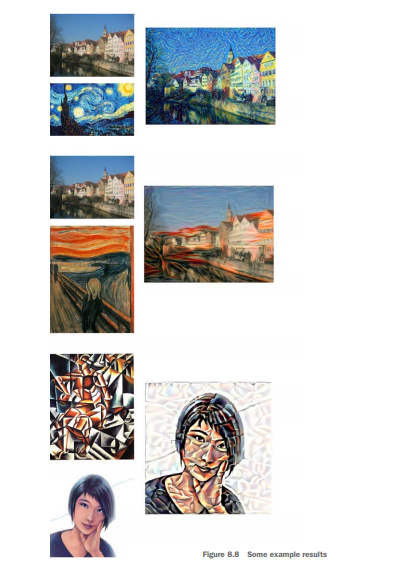

Additionally, note that running this style-transfer algorithm is slow. But the transformation operated by the setup is simple enough that it can be learned by a small, fast
feedforward convnet as well—as long as we have appropriate training data available.

Fast style transfer can thus be achieved by first spending a lot of compute cycles to
generate input-output training examples for a fixed style-reference image, using the
method outlined here, and then training a simple convnet to learn this style-specific
transformation. Once that’s done, stylizing a given image is instantaneous: it’s just a
forward pass of this small convnet. 

### Conclusion

* Style transfer consists of creating a new image that preserves the contents of a
target image while also capturing the style of a reference image.
* Content can be captured by the high-level activations of a convnet.
* Style can be captured by the internal correlations of the activations of different
layers of a convnet.
* Hence, deep learning allows style transfer to be formulated as an optimization
process using a loss defined with a pretrained convnet.
* Starting from this basic idea, many variants and refinements are possible. 